In [1]:
import vamb

import numpy as np
import torch as torch
import torch.nn as nn
from torch.optim import Adam as Adam
from torch.utils.data import DataLoader as DataLoader
from torch.utils.data import TensorDataset

from mlxtend.plotting import category_scatter

import wandb

from sklearn.manifold import TSNE

from collections import namedtuple

import os

import glob

import json

import sys

import pandas as pd

from torchviz import make_dot, make_dot_from_trace

import ast

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
%matplotlib inline

torch.manual_seed(0)

# Load Model

In [2]:
class DISENTANGLED_BETA_VAE(torch.nn.Module):
    def __init__(self, nsamples, config):
        super(DISENTANGLED_BETA_VAE, self).__init__()
  
        # SET UP AND CONFIGURE THE MODEL
        self.ntnf = tnfs.shape[1]
        
        self.nlatent = config.nlatent
        self.dropout = config.dropout
        self.learning_rate = config.learning_rate
        self.alpha = config.alpha
        self.beta = config.beta
        self.nepochs = config.nepochs
        
        nhiddens = [512, 512]
        
        self.nsamples = nsamples
        self.cuda_on = False

        self.encoderlayers = torch.nn.ModuleList()
        self.encodernorms = torch.nn.ModuleList()
        self.decoderlayers = torch.nn.ModuleList()
        self.decodernorms = torch.nn.ModuleList()


        # ENCODER LAYERS
        self.encoderlayers.append( torch.nn.Linear((self.nsamples + self.ntnf), 512) )
        self.encodernorms.append( torch.nn.BatchNorm1d(512) )

        self.encoderlayers.append( torch.nn.Linear(512, 512) )
        self.encodernorms.append( torch.nn.BatchNorm1d(512) )


        # LATENT LAYERS
        self.mu = torch.nn.Linear(512, self.nlatent)
        self.logsigma = torch.nn.Linear(512, self.nlatent)


        # DECODER LAYRS
        self.decoderlayers.append(torch.nn.Linear(self.nlatent, 512))
        self.decodernorms.append(torch.nn.BatchNorm1d(512))

        self.decoderlayers.append(torch.nn.Linear(512, 512))
        self.decodernorms.append(torch.nn.BatchNorm1d(512))


        # RECONSTRUCTION LAYER
        self.outputlayer = torch.nn.Linear(512, (self.nsamples + self.ntnf) )


        # ACTIVATIONS
        self.relu = torch.nn.LeakyReLU()
        self.softplus = torch.nn.Softplus()
        self.dropoutlayer = torch.nn.Dropout(p=self.dropout)

        
    ###
    # ENCODE NEW CONTIGS TO LATENT SPACE
    ###
    def encode(self, data_loader):
        self.eval()

        new_data_loader = DataLoader(dataset=data_loader.dataset,
                                      batch_size=data_loader.batch_size,
                                      shuffle=False,
                                      drop_last=False,
                                      num_workers=1,
                                      pin_memory=data_loader.pin_memory)

        depths_array, tnf_array = data_loader.dataset.tensors
        length = len(depths_array)

        latent = np.empty((length, self.nlatent), dtype=np.float32)

        row = 0
        with torch.no_grad():
            for depths, tnf in new_data_loader:
                if self.cuda_on:
                    depths = depths.cuda()
                    tnf = tnf.cuda()

                # Evaluate
                out_depths, out_tnf, mu, logsigma = self(depths, tnf)

                if self.cuda_on:
                    mu = mu.cpu()

                latent[row: row + len(mu)] = mu
                row += len(mu)

        assert row == length
        return latent
    
    ###
    # SPECIFIC ENCODING AND DECODING FUNCTIONS
    ###
    # REPARAMATERIZE
    def reparameterize(self, mu, logsigma):
        epsilon = torch.randn(mu.size(0), mu.size(1))

        if self.cuda_on:
            epsilon = epsilon.cuda()

        epsilon.requires_grad = True

        # See comment above regarding softplus
        latent = mu + epsilon * torch.exp(logsigma/2)

        return latent
    
    
    # ENCODE CONTIGS
    def encode_contigs(self, tensor):
        tensors = list()

        # Hidden layers
        for encoderlayer, encodernorm in zip(self.encoderlayers, self.encodernorms):
            tensor = encodernorm(self.dropoutlayer(self.relu(encoderlayer(tensor))))
            tensors.append(tensor)

        # Latent layers
        mu = self.mu(tensor)
        logsigma = self.softplus(self.logsigma(tensor))

        return mu, logsigma
    
    
    # DECODE CONTIGS
    def decode_contigs(self, tensor):
        tensors = list()

        for decoderlayer, decodernorm in zip(self.decoderlayers, self.decodernorms):
            tensor = decodernorm(self.dropoutlayer(self.relu(decoderlayer(tensor))))
            tensors.append(tensor)

        reconstruction = self.outputlayer(tensor)

        # Decompose reconstruction to depths and tnf signal
        depths_out = reconstruction.narrow(1, 0, self.nsamples)
        tnf_out = reconstruction.narrow(1, self.nsamples, tnfs.shape[1])

        return depths_out, tnf_out
    
    
    ###
    # LOSS CALCULATION
    ###
    # CALCULATE LOSS
    def calculate_loss(self, depths_in, depths_out, tnf_in, tnf_out, mu, logsigma):
        depths_loss = (depths_out - depths_in).pow(2).sum(dim=1).mean()
        depths_loss_weight = 1 - self.alpha # alpha

        tnfs_loss = (tnf_out - tnf_in).pow(2).sum(dim=1).mean()
        tnfs_loss_weight = (self.alpha / self.ntnf)
        
        kld = -0.5 * (1 + logsigma - mu.pow(2) - logsigma.exp()).sum(dim=1).mean()

        
        # BETA PARAMETER HERE
        loss = (depths_loss * depths_loss_weight) + (tnfs_loss * tnfs_loss_weight) + (self.beta * kld)

        return loss, depths_loss, tnfs_loss, kld
    

    ###
    # TRAINING FUNCTIONS
    ###
    # FORWARD
    def forward(self, depths, tnf):
        tensor = torch.cat((depths, tnf), 1)
        mu, logsigma = self.encode_contigs(tensor)
        latent = self.reparameterize(mu, logsigma)
        depths_out, tnf_out = self.decode_contigs(latent)

        return depths_out, tnf_out, mu, logsigma   
        
     
    
    # TRAIN SPECIFIC EPOCH
    def trainepoch(self, data_loader, epoch, optimizer, batchsteps):
        self.train()

        epoch_loss, epoch_kldloss, epoch_tnfs_loss, epoch_depths_loss = 0, 0, 0, 0

        if epoch in batchsteps:
            data_loader = DataLoader(dataset=data_loader.dataset,
                                      batch_size=data_loader.batch_size * 2,
                                      shuffle=True,
                                      drop_last=True,
                                      num_workers=data_loader.num_workers,
                                      pin_memory=data_loader.pin_memory)

        for depths_in, tnf_in in data_loader:
            depths_in.requires_grad = True
            tnf_in.requires_grad = True

            optimizer.zero_grad()

            depths_out, tnf_out, mu, logsigma = self(depths_in, tnf_in)

            loss, depths_loss, tnfs_loss, kld = self.calculate_loss(depths_in, depths_out, tnf_in,
                                                  tnf_out, mu, logsigma)

            loss.backward()
            optimizer.step()

            epoch_loss = epoch_loss + loss.data.item()
            epoch_kldloss = epoch_kldloss + kld.data.item()
            epoch_tnfs_loss = epoch_tnfs_loss + tnfs_loss.data.item()
            epoch_depths_loss = epoch_depths_loss + depths_loss.data.item()

        print('\tEpoch: {}\tLoss: {:.6f}\tCE: {:.7f}\tSSE: {:.6f}\tKLD: {:.4f}\tBatchsize: {}'.format(
              epoch + 1,
              epoch_loss / len(data_loader),
              epoch_depths_loss / len(data_loader),
              epoch_tnfs_loss / len(data_loader),
              epoch_kldloss / len(data_loader),
              data_loader.batch_size,
              ))
        wandb.log({
            "epoch": (epoch+1), 
            "Loss": epoch_loss / len(data_loader),
            "DepthsLoss": epoch_depths_loss / len(data_loader),
            "TNFsLoss": epoch_tnfs_loss / len(data_loader),
            "KLDLoss": epoch_kldloss / len(data_loader),
            "Batchsize": data_loader.batch_size
        })

        return data_loader
    
    
    
    # TRAIN MODEL    
    def trainmodel(self, dataloader, batchsteps=[25, 75, 150, 300], modelfile=None):
        
        batchsteps_set = set()
        
        ncontigs, nsamples = dataloader.dataset.tensors[0].shape
        optimizer = Adam(self.parameters(), lr=self.learning_rate)
        
        
        # TRAIN EPOCH
        for epoch in range(self.nepochs):
            dataloader = self.trainepoch(dataloader, epoch, optimizer, batchsteps_set)

# Load In Data

In [3]:
BASE_DIR = os.getcwd()

In [4]:
def filterclusters(clusters, lengthof):
    filtered_bins = dict()
    print('CLUSTERS:', len(clusters))
    for medoid, contigs in clusters.items():
        binsize = sum(lengthof[contig] for contig in contigs)
    
        if binsize >= 10000:
            filtered_bins[medoid] = contigs
    
    return filtered_bins

In [19]:
SIM_FASTA_FILES =  glob.glob('example_input_data/new_simulations/complexity_sim*/*sample_0*')


for SIM_FASTA_FILE in SIM_FASTA_FILES:
    vamb_inputs_base = os.path.join(SIM_FASTA_FILE,'vamb_inputs')
    
    contignames = vamb.vambtools.read_npz(os.path.join(vamb_inputs_base, 'contignames.npz'))
    lengths = vamb.vambtools.read_npz(os.path.join(vamb_inputs_base, 'lengths.npz'))
    tnfs = vamb.vambtools.read_npz(os.path.join(vamb_inputs_base, 'tnfs.npz'))   
    rpkms = vamb.vambtools.read_npz(os.path.join(vamb_inputs_base, 'rpkms.npz'))
    
    print(tnfs.shape)
    print(rpkms.shape)
    
    
    # ADAPT THROUGH DATALOADER
    depthssum = rpkms.sum(axis=1)
    mask = tnfs.sum(axis=1) != 0
    mask &= depthssum != 0
    depthssum = depthssum[mask]

    rpkm = rpkms[mask].astype(np.float32, copy=False)
    tnf = tnfs[mask].astype(np.float32, copy=False)

    
    def calculate_z_score(array):
        array_mean = array.mean(axis=0)
        array_std = array.std(axis=0)

        shape = np.copy(array.shape)
        shape[0] = 1
        shape = tuple(shape)

        array_mean.shape = shape
        array_mean.shape = shape

        array = (array - array_mean) / array_std

        return(array)

    rpkm = calculate_z_score(rpkm)
    tnf = calculate_z_score(tnf)
    depthstensor = torch.from_numpy(rpkm)
    tnftensor = torch.from_numpy(tnf)

    n_workers = 1

    dataset = TensorDataset(depthstensor, tnftensor)
    dataloader = DataLoader(dataset=dataset, batch_size=256, drop_last=True,
                                 shuffle=True, num_workers=n_workers, pin_memory=False)



    ncontigs, nsamples = dataset.tensors[0].shape
    
    
    # RUN BETA VAE
    best_params_dict = {
        'nepochs': 150,
        'dropout': 0.2,
        'learning_rate': 1e-3,
        'alpha': 0.15,
        'beta': 50,
        'nlatent': 32
    }

    best_params = namedtuple('GenericDict', best_params_dict.keys())(**best_params_dict)

    beta_vae = DISENTANGLED_BETA_VAE(nsamples=rpkms.shape[1], config=best_params)
    
    #torch.onnx.export(beta_vae, (torch.randn(256,1), torch.randn(256,103)), "beta_vae.onnx", verbose=True)
   
    wandb.init()
    wandb.watch(beta_vae)
    beta_vae.trainmodel(dataloader, batchsteps=None)
    #beta_vae.load_state_dict(torch.load('model.h5'))

    latent = beta_vae.encode(dataloader)
    print("Latent shape:", latent.shape)

    latent_output_path = os.path.join(SIM_FASTA_FILE, 'latent_space.npy')
    with open(latent_output_path, 'wb') as outfile:
        np.save(outfile, latent)
        
        
    # CONTIG MAPPING
    contig_mapping_table_path = os.path.join(BASE_DIR, f"{SIM_FASTA_FILE}/contigs/gsa_mapping.tsv")
    contig_mapping_table_comp = contig_mapping_table_path + '.gz'
    if (not os.path.exists(contig_mapping_table_path)) and (os.path.exists(contig_mapping_table_comp)):
        !gzip -d $contig_mapping_table_comp
        
    contig_mapping_table = pd.read_csv(contig_mapping_table_path, sep='\t')
    

    contig_mapping_output_path = os.path.join(BASE_DIR, f"{SIM_FASTA_FILE}/encoding_mapping.tsv")    

    contig_mapping_table[contig_mapping_table['#anonymous_contig_id'].isin(contignames)].reset_index().drop('index', axis=1).set_index(
        '#anonymous_contig_id').reindex(contignames).to_csv(contig_mapping_output_path, sep='\t')
    
    
    filtered_labels = [n for (n,m) in zip(contignames, mask) if m]
    cluster_iterator = vamb.cluster.cluster(latent, labels=filtered_labels)
    clusters = dict(cluster_iterator)

    medoid, contigs = next(iter(clusters.items()))
    print('First key:', medoid, '(of type:', type(medoid), ')')
    print('Type of values:', type(contigs))
    print('First element of value:', next(iter(contigs)), 'of type:', type(next(iter(contigs))))
    
    
    # FILTER CLUSTERS  
    lengthof = dict(zip(contignames, lengths))
    filtered_bins = filterclusters(vamb.vambtools.binsplit(clusters, 'C'), lengthof)
    print('Number of bins before splitting and filtering:', len(clusters))
    print('Number of bins after splitting and filtering:', len(filtered_bins))
    
    
    # SAVE OUTPUTS
    vamb_outputs_base = os.path.join(BASE_DIR, SIM_FASTA_FILE)


    # This writes a .tsv file with the clusters and corresponding sequences
    with open(os.path.join(vamb_outputs_base, 'clusters_dvae.tsv'), 'w') as file:
        vamb.vambtools.write_clusters(file, filtered_bins)

    # Only keep contigs in any filtered bin in memory
    keptcontigs = set.union(*filtered_bins.values())

    # decompress fasta.gz if present
    fasta_path = os.path.join(BASE_DIR, f"{SIM_FASTA_FILE}/contigs/anonymous_gsa.fasta.gz")
    if os.path.exists(fasta_path) and not os.path.exists(fasta_path.replace('.fasta.gz','.fasta')):
        !gzip -dk $fasta_path


    with open(os.path.join(BASE_DIR, f"{SIM_FASTA_FILE}/contigs/anonymous_gsa.fasta"), 'rb') as file:
        fastadict = vamb.vambtools.loadfasta(file, keep=keptcontigs)

    bindir = os.path.join(vamb_outputs_base, 'dvae_bins')
    if not os.path.exists(bindir):
        os.mkdir(bindir)
    vamb.vambtools.write_bins(bindir, filtered_bins, fastadict, maxbins=500)
    
    
    # RUN CHECKM
    CHECKM_OUTDIR = os.path.join(BASE_DIR, SIM_FASTA_FILE, 'checkm_results')
    CHECKM_TAXONOMY_OUTDIR = os.path.join(BASE_DIR, SIM_FASTA_FILE, 'checkm_taxonomy_results')

    if not os.path.exists(CHECKM_OUTDIR):
        os.mkdir(CHECKM_OUTDIR)

        
    bins_inpath = os.path.join(BASE_DIR, SIM_FASTA_FILE, 'dvae_bins')
    bins_inpath_clean = os.path.join(BASE_DIR, SIM_FASTA_FILE, 'dvae_bins_clean')
    
    if not os.path.exists(bins_inpath_clean):
        os.mkdir(bins_inpath_clean)

    for bin_file in glob.glob(os.path.join(bins_inpath,'*')):
        bin_outfile = bin_file.replace('dvae_bins','dvae_bins_clean')
        !sed -e 's/\r$//' $bin_file > $bin_outfile

    !~/miniconda3/envs/vamb_env/bin/checkm lineage_wf -t 32 -x fna $bins_inpath_clean $CHECKM_OUTDIR

    #!~/miniconda3/envs/vamb_env/bin/checkm taxonomy_wf -t 32 -x fna genus Escherichia $bins_inpath_clean $CHECKM_TAXONOMY_OUTDIR

(774, 103)
(774, 1)


epoch,150
Loss,1.02277
DepthsLoss,1.01209
TNFsLoss,104.39999
KLDLoss,0.00209
Batchsize,256
_runtime,32
_timestamp,1615954110
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Loss,█▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
DepthsLoss,█▅▃▂▂▂▂▁▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▂
TNFsLoss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
KLDLoss,█▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 590.821228	CE: 1.5441118	SSE: 137.398432	KLD: 11.7862	Batchsize: 256
	Epoch: 2	Loss: 463.684408	CE: 1.4817408	SSE: 132.934107	KLD: 9.2446	Batchsize: 256
	Epoch: 3	Loss: 404.617889	CE: 1.5028221	SSE: 126.804278	KLD: 8.0631	Batchsize: 256
	Epoch: 4	Loss: 371.813721	CE: 1.4220814	SSE: 125.378749	KLD: 7.4084	Batchsize: 256
	Epoch: 5	Loss: 343.538727	CE: 1.2534772	SSE: 123.066099	KLD: 6.8459	Batchsize: 256
	Epoch: 6	Loss: 326.899882	CE: 1.2990793	SSE: 121.198631	KLD: 6.5124	Batchsize: 256
	Epoch: 7	Loss: 311.535482	CE: 1.2700090	SSE: 120.216573	KLD: 6.2056	Batchsize: 256
	Epoch: 8	Loss: 299.262980	CE: 1.2087947	SSE: 118.851644	KLD: 5.9612	Batchsize: 256
	Epoch: 9	Loss: 283.861420	CE: 1.1644421	SSE: 118.291723	KLD: 5.6540	Batchsize: 256
	Epoch: 10	Loss: 273.371236	CE: 1.2233541	SSE: 117.655774	KLD: 5.4432	Batchsize: 256
	Epoch: 11	Loss: 260.159007	CE: 1.1864754	SSE: 116.425133	KLD: 5.1796	Batchsize: 256
	Epoch: 12	Loss: 246.563680	CE: 1.0985634	SSE: 115.639270	KLD: 4.9092	Bat

epoch,150
Loss,1.4899
DepthsLoss,1.01033
TNFsLoss,103.07446
KLDLoss,0.00962
Batchsize,256
_runtime,18
_timestamp,1615955423
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Loss,█▇▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
DepthsLoss,█▇▄▂▃▂▂▂▁▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
TNFsLoss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▂▁▁
KLDLoss,█▇▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 628.193695	CE: 1.3098006	SSE: 135.991295	KLD: 12.5376	Batchsize: 256
	Epoch: 2	Loss: 521.957886	CE: 1.6434153	SSE: 134.120087	KLD: 10.4073	Batchsize: 256
	Epoch: 3	Loss: 470.429703	CE: 1.3049104	SSE: 132.614014	KLD: 9.3825	Batchsize: 256
	Epoch: 4	Loss: 430.331268	CE: 1.4306890	SSE: 128.505600	KLD: 8.5786	Batchsize: 256
	Epoch: 5	Loss: 404.191223	CE: 1.5298437	SSE: 127.995495	KLD: 8.0541	Batchsize: 256
	Epoch: 6	Loss: 380.006363	CE: 1.3301027	SSE: 124.474648	KLD: 7.5739	Batchsize: 256
	Epoch: 7	Loss: 364.754135	CE: 1.1852757	SSE: 124.016258	KLD: 7.2713	Batchsize: 256
	Epoch: 8	Loss: 348.979309	CE: 1.2871520	SSE: 124.074512	KLD: 6.9541	Batchsize: 256
	Epoch: 9	Loss: 335.124878	CE: 1.2554113	SSE: 121.973000	KLD: 6.6776	Batchsize: 256
	Epoch: 10	Loss: 321.046768	CE: 1.2230519	SSE: 120.594467	KLD: 6.3966	Batchsize: 256
	Epoch: 11	Loss: 311.050827	CE: 1.2288833	SSE: 118.555080	KLD: 6.1967	Batchsize: 256
	Epoch: 12	Loss: 304.698044	CE: 1.1823905	SSE: 117.458096	KLD: 6.0704	Ba

epoch,150
Loss,2.22749
DepthsLoss,1.00756
TNFsLoss,105.85048
KLDLoss,0.02434
Batchsize,256
_runtime,17
_timestamp,1615955894
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Loss,█▇▆▅▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
DepthsLoss,█▆▄▃▃▂▂▂▂▁▂▂▂▁▂▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
TNFsLoss,█▇▆▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
KLDLoss,█▇▆▅▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 498.982365	CE: 1.3853401	SSE: 132.721660	KLD: 9.9522	Batchsize: 256
	Epoch: 2	Loss: 368.631042	CE: 1.3349999	SSE: 124.398049	KLD: 7.3463	Batchsize: 256
	Epoch: 3	Loss: 313.398640	CE: 1.1842269	SSE: 119.842587	KLD: 6.2444	Batchsize: 256
	Epoch: 4	Loss: 274.428638	CE: 1.1674093	SSE: 116.911540	KLD: 5.4653	Batchsize: 256
	Epoch: 5	Loss: 238.268133	CE: 1.1525436	SSE: 114.958115	KLD: 4.7424	Batchsize: 256
	Epoch: 6	Loss: 200.425625	CE: 1.0930634	SSE: 113.049872	KLD: 3.9866	Batchsize: 256
	Epoch: 7	Loss: 158.474342	CE: 1.0759758	SSE: 111.742072	KLD: 3.1479	Batchsize: 256
	Epoch: 8	Loss: 119.602713	CE: 1.0524449	SSE: 110.802160	KLD: 2.3709	Batchsize: 256
	Epoch: 9	Loss: 88.201074	CE: 1.0608088	SSE: 109.743782	KLD: 1.7428	Batchsize: 256
	Epoch: 10	Loss: 64.100286	CE: 1.0369897	SSE: 108.976233	KLD: 1.2612	Batchsize: 256
	Epoch: 11	Loss: 47.159585	CE: 1.0535977	SSE: 108.794504	KLD: 0.9221	Batchsize: 256
	Epoch: 12	Loss: 35.275601	CE: 1.0422393	SSE: 108.361538	KLD: 0.6846	Batchsiz

epoch,150
Loss,1.08549
DepthsLoss,1.02081
TNFsLoss,104.41807
KLDLoss,0.00131
Batchsize,256
_runtime,29
_timestamp,1615956359
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Loss,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
DepthsLoss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
TNFsLoss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
KLDLoss,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 492.712809	CE: 1.4168568	SSE: 132.773088	KLD: 9.8263	Batchsize: 256
	Epoch: 2	Loss: 353.071113	CE: 1.2923124	SSE: 123.748589	KLD: 7.0358	Batchsize: 256
	Epoch: 3	Loss: 302.749532	CE: 1.2814352	SSE: 118.433836	KLD: 6.0298	Batchsize: 256
	Epoch: 4	Loss: 264.549327	CE: 1.1637961	SSE: 115.597578	KLD: 5.2678	Batchsize: 256
	Epoch: 5	Loss: 224.492191	CE: 1.1275204	SSE: 113.773855	KLD: 4.4674	Batchsize: 256
	Epoch: 6	Loss: 178.636631	CE: 1.1116216	SSE: 112.511125	KLD: 3.5506	Batchsize: 256
	Epoch: 7	Loss: 133.465519	CE: 1.1169151	SSE: 110.695541	KLD: 2.6471	Batchsize: 256
	Epoch: 8	Loss: 95.150369	CE: 1.0890505	SSE: 109.788830	KLD: 1.8813	Batchsize: 256
	Epoch: 9	Loss: 66.338395	CE: 1.0620235	SSE: 109.031891	KLD: 1.3055	Batchsize: 256
	Epoch: 10	Loss: 46.704337	CE: 1.0689039	SSE: 108.526215	KLD: 0.9128	Batchsize: 256
	Epoch: 11	Loss: 34.596944	CE: 1.0427305	SSE: 108.103795	KLD: 0.6711	Batchsize: 256
	Epoch: 12	Loss: 26.727080	CE: 1.0550316	SSE: 108.241845	KLD: 0.5135	Batchsize

epoch,150
Loss,1.10762
DepthsLoss,1.03991
TNFsLoss,104.05249
KLDLoss,0.00144
Batchsize,256
_runtime,32
_timestamp,1615956988
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Loss,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
DepthsLoss,█▆▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▁▄▄▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
TNFsLoss,█▅▃▃▂▂▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁
KLDLoss,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 525.241669	CE: 1.3986919	SSE: 134.272659	KLD: 10.4771	Batchsize: 256
	Epoch: 2	Loss: 395.081655	CE: 1.3644971	SSE: 126.268191	KLD: 7.8748	Batchsize: 256
	Epoch: 3	Loss: 340.225052	CE: 1.2255007	SSE: 121.726377	KLD: 6.7801	Batchsize: 256
	Epoch: 4	Loss: 309.172633	CE: 1.2237618	SSE: 118.673644	KLD: 6.1592	Batchsize: 256
	Epoch: 5	Loss: 281.004374	CE: 1.1910733	SSE: 117.921196	KLD: 5.5964	Batchsize: 256
	Epoch: 6	Loss: 257.197281	CE: 1.1735320	SSE: 115.074036	KLD: 5.1206	Batchsize: 256
	Epoch: 7	Loss: 230.935727	CE: 1.0998876	SSE: 114.411626	KLD: 4.5967	Batchsize: 256
	Epoch: 8	Loss: 202.088710	CE: 1.1034541	SSE: 112.751914	KLD: 4.0197	Batchsize: 256
	Epoch: 9	Loss: 172.921992	CE: 1.0825650	SSE: 112.372467	KLD: 3.4368	Batchsize: 256
	Epoch: 10	Loss: 143.445605	CE: 1.0447198	SSE: 110.594381	KLD: 2.8479	Batchsize: 256
	Epoch: 11	Loss: 116.708111	CE: 1.0555211	SSE: 111.383811	KLD: 2.3130	Batchsize: 256
	Epoch: 12	Loss: 92.893890	CE: 1.0725611	SSE: 109.425443	KLD: 1.8365	Batc

epoch,150
Loss,1.14148
DepthsLoss,1.0175
TNFsLoss,104.32156
KLDLoss,0.00249
Batchsize,256
_runtime,27
_timestamp,1615957593
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Loss,█▆▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
DepthsLoss,█▅▃▃▂▁▁▂▁▂▁▂▁▂▁▂▂▁▁▁▁▁▁▁▁▂▁▂▁▁▁▂▁▁▂▁▂▁▂▂
TNFsLoss,█▆▄▃▂▂▂▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▂▁▁▁
KLDLoss,█▆▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 471.674755	CE: 1.4182300	SSE: 131.054540	KLD: 9.4056	Batchsize: 256
	Epoch: 2	Loss: 331.373901	CE: 1.2767884	SSE: 120.872077	KLD: 6.6023	Batchsize: 256
	Epoch: 3	Loss: 271.137608	CE: 1.1798286	SSE: 117.039578	KLD: 5.3993	Batchsize: 256
	Epoch: 4	Loss: 219.229459	CE: 1.1392212	SSE: 114.534094	KLD: 4.3619	Batchsize: 256
	Epoch: 5	Loss: 163.217826	CE: 1.0776478	SSE: 111.636362	KLD: 3.2428	Batchsize: 256
	Epoch: 6	Loss: 109.677103	CE: 1.0617403	SSE: 110.410060	KLD: 2.1723	Batchsize: 256
	Epoch: 7	Loss: 70.212762	CE: 1.0529492	SSE: 109.683160	KLD: 1.3832	Batchsize: 256
	Epoch: 8	Loss: 45.199902	CE: 1.0492365	SSE: 108.589041	KLD: 0.8830	Batchsize: 256
	Epoch: 9	Loss: 31.049441	CE: 1.0461184	SSE: 108.348425	KLD: 0.6000	Batchsize: 256
	Epoch: 10	Loss: 22.579721	CE: 1.0366173	SSE: 108.023231	KLD: 0.4308	Batchsize: 256
	Epoch: 11	Loss: 17.964219	CE: 1.0356618	SSE: 106.539905	KLD: 0.3386	Batchsize: 256
	Epoch: 12	Loss: 14.126718	CE: 1.0371452	SSE: 106.610820	KLD: 0.2618	Batchsize:

epoch,150
Loss,1.05567
DepthsLoss,1.00419
TNFsLoss,104.0129
KLDLoss,0.00101
Batchsize,256
_runtime,38
_timestamp,1615958296
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
DepthsLoss,█▄▂▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
TNFsLoss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
KLDLoss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 587.405579	CE: 1.4710236	SSE: 136.086288	KLD: 11.7191	Batchsize: 256
	Epoch: 2	Loss: 502.298691	CE: 1.5781598	SSE: 134.129829	KLD: 10.0152	Batchsize: 256
	Epoch: 3	Loss: 446.433304	CE: 1.5065634	SSE: 130.071011	KLD: 8.8993	Batchsize: 256
	Epoch: 4	Loss: 408.611420	CE: 1.4675410	SSE: 127.713520	KLD: 8.1436	Batchsize: 256
	Epoch: 5	Loss: 382.017242	CE: 1.2787126	SSE: 126.539890	KLD: 7.6149	Batchsize: 256
	Epoch: 6	Loss: 365.471268	CE: 1.4376338	SSE: 125.663635	KLD: 7.2813	Batchsize: 256
	Epoch: 7	Loss: 352.139954	CE: 1.4840546	SSE: 122.261497	KLD: 7.0140	Batchsize: 256
	Epoch: 8	Loss: 334.671799	CE: 1.2051327	SSE: 121.348858	KLD: 6.6694	Batchsize: 256
	Epoch: 9	Loss: 320.505844	CE: 1.2478844	SSE: 121.551422	KLD: 6.3854	Batchsize: 256
	Epoch: 10	Loss: 312.954361	CE: 1.1437083	SSE: 120.738659	KLD: 6.2361	Batchsize: 256
	Epoch: 11	Loss: 300.869476	CE: 1.1106850	SSE: 118.095825	KLD: 5.9951	Batchsize: 256
	Epoch: 12	Loss: 290.761902	CE: 1.1775822	SSE: 117.765324	KLD: 5.7918	Ba

epoch,150
Loss,2.02838
DepthsLoss,1.03436
TNFsLoss,105.43175
KLDLoss,0.01991
Batchsize,256
_runtime,19
_timestamp,1615958825
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Loss,█▇▆▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
DepthsLoss,█▇▅▄▄▄▄▄▃▃▄▂▃▃▄▂▃▃▃▃▁▃▂▃▃▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃
TNFsLoss,█▇▅▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▂▂▁▂▂▁▂▁▂▁▁▁▂
KLDLoss,█▇▆▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 522.081228	CE: 1.4873380	SSE: 133.991038	KLD: 10.4124	Batchsize: 256
	Epoch: 2	Loss: 393.656448	CE: 1.3861383	SSE: 126.385707	KLD: 7.8459	Batchsize: 256
	Epoch: 3	Loss: 336.610509	CE: 1.3417141	SSE: 122.109870	KLD: 6.7058	Batchsize: 256
	Epoch: 4	Loss: 299.628733	CE: 1.2728612	SSE: 119.939912	KLD: 5.9674	Batchsize: 256
	Epoch: 5	Loss: 270.671295	CE: 1.1521264	SSE: 116.317886	KLD: 5.3905	Batchsize: 256
	Epoch: 6	Loss: 243.336980	CE: 1.1491751	SSE: 114.842678	KLD: 4.8439	Batchsize: 256
	Epoch: 7	Loss: 214.022217	CE: 1.1478185	SSE: 113.377366	KLD: 4.2576	Batchsize: 256
	Epoch: 8	Loss: 182.033335	CE: 1.1046453	SSE: 112.133933	KLD: 3.6186	Batchsize: 256
	Epoch: 9	Loss: 151.145421	CE: 1.0688116	SSE: 112.057879	KLD: 3.0015	Batchsize: 256
	Epoch: 10	Loss: 120.102315	CE: 1.0557506	SSE: 111.538287	KLD: 2.3808	Batchsize: 256
	Epoch: 11	Loss: 93.099112	CE: 1.0789127	SSE: 110.206270	KLD: 1.8404	Batchsize: 256
	Epoch: 12	Loss: 72.537448	CE: 1.0308021	SSE: 109.787590	KLD: 1.4300	Batch

epoch,150
Loss,1.1404
DepthsLoss,1.03365
TNFsLoss,104.36226
KLDLoss,0.0022
Batchsize,256
_runtime,29
_timestamp,1615959252
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Loss,█▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
DepthsLoss,█▆▃▂▂▂▁▂▂▂▂▁▂▂▂▁▂▁▂▂▁▂▁▁▂▂▁▁▂▂▁▁▁▂▂▁▁▁▂▂
TNFsLoss,█▆▄▃▂▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁
KLDLoss,█▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 489.993079	CE: 1.5144636	SSE: 131.861709	KLD: 9.7703	Batchsize: 256
	Epoch: 2	Loss: 350.968197	CE: 1.3485110	SSE: 123.082371	KLD: 6.9929	Batchsize: 256
	Epoch: 3	Loss: 296.568058	CE: 1.2175758	SSE: 119.206222	KLD: 5.9072	Batchsize: 256
	Epoch: 4	Loss: 257.419757	CE: 1.1624384	SSE: 116.075799	KLD: 5.1253	Batchsize: 256
	Epoch: 5	Loss: 214.886407	CE: 1.1305369	SSE: 114.358966	KLD: 4.2752	Batchsize: 256
	Epoch: 6	Loss: 167.150857	CE: 1.0975257	SSE: 112.621598	KLD: 3.3211	Batchsize: 256
	Epoch: 7	Loss: 122.280793	CE: 1.0604364	SSE: 110.894778	KLD: 2.4244	Batchsize: 256
	Epoch: 8	Loss: 84.910399	CE: 1.0248954	SSE: 109.759502	KLD: 1.6776	Batchsize: 256
	Epoch: 9	Loss: 58.754219	CE: 1.0618146	SSE: 109.533309	KLD: 1.1538	Batchsize: 256
	Epoch: 10	Loss: 41.329795	CE: 1.0360596	SSE: 108.450125	KLD: 0.8058	Batchsize: 256
	Epoch: 11	Loss: 30.841368	CE: 1.0124662	SSE: 107.710764	KLD: 0.5965	Batchsize: 256
	Epoch: 12	Loss: 23.552451	CE: 1.0378866	SSE: 106.948207	KLD: 0.4503	Batchsize

In [20]:
print('done')

done


In [87]:
best_params_dict['beta'] = 800

# Compile Outputs

In [88]:
SIM_FASTA_FILES =  glob.glob('example_input_data/new_simulations/complexity_sim*/*sample_0*')

experiment_beta = best_params_dict['beta'] 

experiment_path = f"experiment_beta{experiment_beta}"

if not os.path.exists(experiment_path):
    os.mkdir(experiment_path)

# CHECKM DATA
num_generas = []
num_genomes = []
num_bins = []
num_mappable_bins = []
mean_completenesses = []
mean_contaminations = []

# CHECKM TAXA
num_generas_taxa = []
num_genomes_taxa = []
num_bins_taxa = []
num_mappable_bins_taxa = []
mean_completenesses_taxa = []
mean_contaminations_taxa = []


for SIM_FASTA_FILE in SIM_FASTA_FILES:
    num_genera, num_genome = SIM_FASTA_FILE.split('/')[-2].split('_')[2], SIM_FASTA_FILE.split('/')[-2].split('_')[4]
    
    checkm_data = os.path.join(SIM_FASTA_FILE, 'checkm_results')
    checkm_taxonomy_data = os.path.join(SIM_FASTA_FILE, 'checkm_taxonomy_results')

    num_bin = len(glob.glob(os.path.join(checkm_data,'bins','*')))
    
    
    for idx,t1 in enumerate([checkm_data, checkm_taxonomy_data]):
       
        
        t1 = pd.read_csv( os.path.join(checkm_data, 'storage', 'bin_stats_ext.tsv'), sep ='\t', names=['contig', 'data'])
        t1 = t1[~t1['data'].str.contains("'Completeness': 0.0")]
        num_mappable_bin = len(t1)

        completeness = np.array([ast.literal_eval(i)['Completeness'] for i in t1['data'].values])
        contamination = np.array([ast.literal_eval(i)['Contamination'] for i in t1['data'].values])

        mean_completeness = completeness.mean()
        mean_contamination = contamination.mean()

        if idx == 0:
            num_generas.append(num_genera)
            num_genomes.append(num_genome)
            num_bins.append(num_bin)
            num_mappable_bins.append(num_mappable_bin)
            mean_completenesses.append(mean_completeness)
            mean_contaminations.append(mean_contamination)

            experiment_stats = pd.DataFrame(data={
                'num_genera':num_generas,
                'num_genomes':num_genomes,
                'num_bins':num_bins,
                'num_mappable_bins':num_mappable_bins,
                'mean_completeness':mean_completenesses,
                'mean_contamination':mean_contaminations,
                'beta':experiment_beta,
                'dropout':best_params_dict['dropout']
            })

            experiment_stats.to_csv(f"{experiment_path}/experiment_stats_beta{experiment_beta}.tsv", sep='\t', index=False)
        
        elif idx == 1:
            num_generas_taxa.append(num_genera)
            num_genomes_taxa.append(num_genome)
            num_bins_taxa.append(num_bin)
            num_mappable_bins_taxa.append(num_mappable_bin)
            mean_completenesses_taxa.append(mean_completeness)
            mean_contaminations_taxa.append(mean_contamination)

            experiment_stats = pd.DataFrame(data={
                'num_genera':num_generas_taxa,
                'num_genomes':num_genomes_taxa,
                'num_bins':num_bins_taxa,
                'num_mappable_bins':num_mappable_bins_taxa,
                'mean_completeness':mean_completenesses_taxa,
                'mean_contamination':mean_contaminations_taxa,
                'beta':experiment_beta,
                'dropout':best_params_dict['dropout']
            })
            experiment_stats.to_csv(f"{experiment_path}/experiment_stats_beta{experiment_beta}_taxonomy.tsv", sep='\t', index=False)
        
    
    
    latent_encoding_labels = pd.read_csv(glob.glob(os.path.join(SIM_FASTA_FILE, 'encoding_mapping.tsv'))[0], sep='\t')
    latent_output_path = glob.glob(os.path.join(SIM_FASTA_FILE, 'latent_space.npy'))[0]

    with open(latent_output_path, 'rb') as infile:
        latent_space = np.load(infile)

    tsne_results = pd.DataFrame(TSNE(n_components=2).fit_transform(latent_space))
    tsne_results['genome_id'] = latent_encoding_labels['genome_id']
    tsne_filename = SIM_FASTA_FILE.split('/')[-2]
    tsne_results.to_csv(os.path.join(experiment_path, f"{tsne_filename}_tsne.tsv"), sep='\t')

Saving tSNE to file: experiment_beta800 complexity_sim_10_genera_250_genomes
Saving tSNE to file: experiment_beta800 complexity_sim_1_genera_250_genomes
Saving tSNE to file: experiment_beta800 complexity_sim_1_genera_25_genomes
Saving tSNE to file: experiment_beta800 complexity_sim_5_genera_50_genomes
Saving tSNE to file: experiment_beta800 complexity_sim_10_genera_25_genomes
Saving tSNE to file: experiment_beta800 complexity_sim_1_genera_50_genomes
Saving tSNE to file: experiment_beta800 complexity_sim_5_genera_250_genomes
Saving tSNE to file: experiment_beta800 complexity_sim_5_genera_25_genomes
Saving tSNE to file: experiment_beta800 complexity_sim_10_genera_50_genomes


In [89]:
tsne_results

,0,1,genome_id
0,1.939338,2.470517,AFYK01000058.1
1,-35.272579,-38.168839,LKEJ01000101.1
2,-0.009174,18.658964,BBAU01000031.1
3,9.868030,-43.129818,LKEJ01000046.1
4,58.966316,-8.724900,BBRZ01000002.1
...,...,...,...
2420,-17.792200,62.684341,CM001047.1
2421,18.549541,46.044846,CM001047.1
2422,-36.165546,-31.083395,LKEJ01000001.1
2423,2.124083,-18.499506,AFYK01000029.1


In [68]:
all_stats = pd.concat([pd.read_csv(i, sep='\t') for i in glob.glob('experiment_beta*/experiment_stats_beta*.tsv')])
all_stats[(all_stats['num_genomes'].isin([25, 250])) & (all_stats['num_genera'].isin([1, 10]))].sort_values(by=['beta','num_genera','num_genomes']).drop_duplicates()

,num_genera,num_genomes,num_bins,num_mappable_bins,mean_completeness,mean_contamination,beta,dropout
2,1,25,245,34,23.506212,3.512819,1,0.2
1,1,250,166,24,28.656769,1.178638,1,0.2
4,10,25,334,56,15.833097,0.771620,1,0.2
0,10,250,86,40,33.324798,0.297408,1,0.2
2,1,25,212,17,19.194367,1.557420,200,0.2
1,1,250,142,14,24.122196,0.870878,200,0.2
4,10,25,295,33,9.634855,0.135959,200,0.2
0,10,250,51,19,35.105822,0.314559,200,0.2
2,1,25,200,16,14.524375,1.323912,400,0.2
1,1,250,139,12,19.340885,0.948323,400,0.2


# Display Contamination and Bin Count Relationships

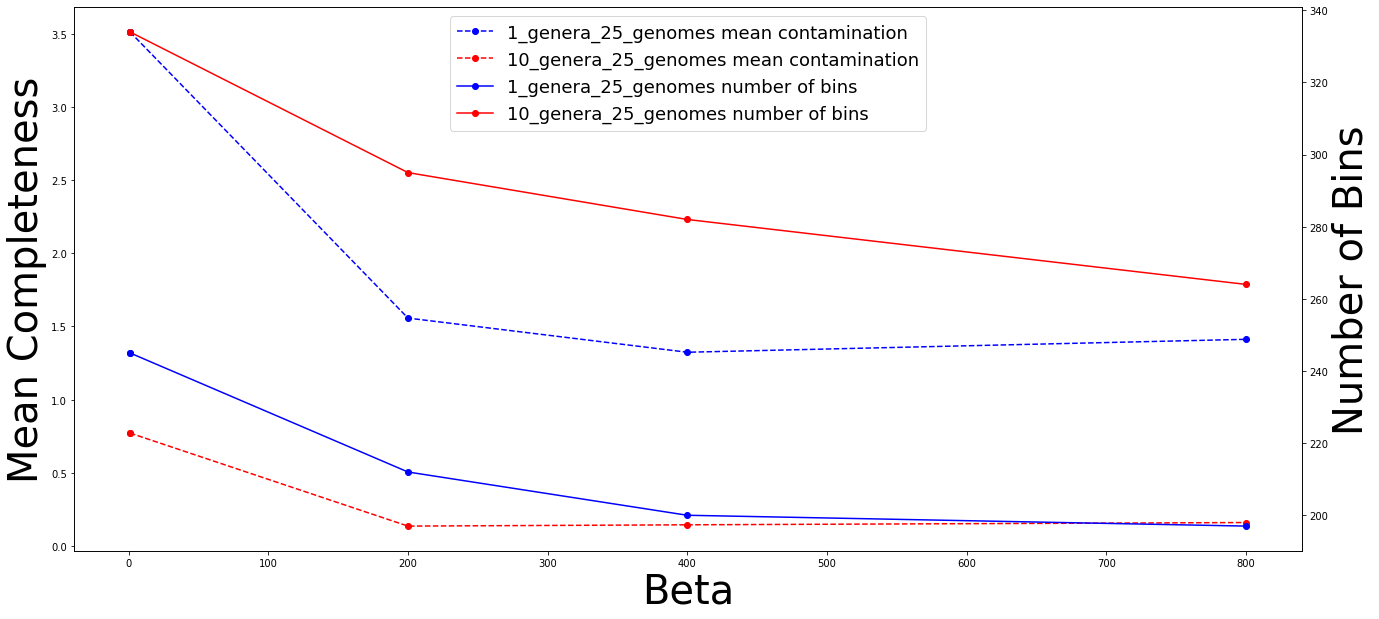

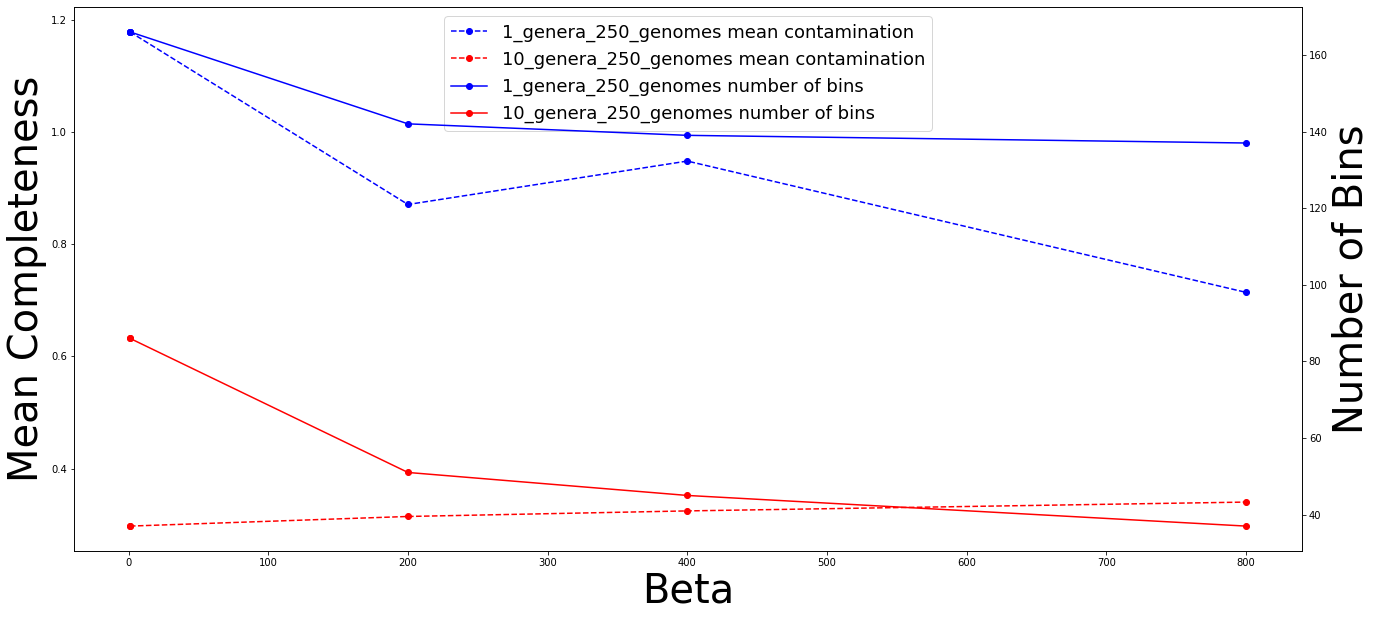

In [57]:
experiment_stats_all = pd.concat([pd.read_csv(i, sep='\t') for i in glob.glob('experiment_beta*/experiment_stats*.tsv')])
experiment_stats_all = experiment_stats_all[experiment_stats_all['beta']<1000]
experiment_stats_all['experiment'] = experiment_stats_all['num_genera'].astype(str) + '_genera_' + experiment_stats_all['num_genomes'].astype(str) + '_genomes'
experiment_stats_all = experiment_stats_all.sort_values(by=['beta','num_genera','num_genomes'])


#fig = category_scatter(x='beta', y='mean_contamination', label_col='experiment', 
#                       data=experiment_stats_all, legend_loc='upper left')



colors = ['blue','red','green']

experiment_types = [25, 250]

for experiment_type in experiment_types:
    experiment_type_df = experiment_stats_all[(experiment_stats_all['num_genomes']==experiment_type) & (~experiment_stats_all['experiment'].str.contains('5_genera'))]
    
    #plt.figure(figsize=(22,10))
    
    fig,ax = plt.subplots(figsize=(22,10))
    
    ax.set_xlabel("Beta", fontsize=40)
    ax.set_ylabel("Mean Completeness", fontsize=40)
    
    ax2=ax.twinx()
    ax2.set_ylabel("Number of Bins", fontsize=40)

    for experiment, color in zip(experiment_type_df['experiment'].unique(), colors):
        experiment_df = experiment_type_df[experiment_type_df['experiment']==experiment]
        ax.plot(experiment_df['beta'], experiment_df['mean_contamination'], label=experiment+' mean contamination', color=color, linestyle='--', marker="o")
        ax2.plot(experiment_df['beta'], experiment_df['num_bins'], label=experiment+' number of bins', color=color, linestyle='-', marker="o")
        #plt.plot(experiment_df['beta'], experiment_df['mean_contamination'], label=experiment, color=color, linestyle='--')
        #plt.plot(experiment_df['beta'], experiment_df['num_bins'], label=experiment, color=color, linestyle='-')


    #plt.xlabel('Beta')
    #plt.ylabel('Mean Contamination')
    
    
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_all = lines_1 + lines_2
    labels_all = labels_1 + labels_2

    ax.legend(lines_all, labels_all, loc='upper center', prop={"size":18})
    plt.show()

# Visualize Encoding Space

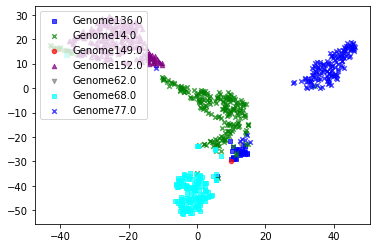

In [15]:
tsne_results = pd.read_csv('experiment_beta1/complexity_sim_10_genera_250_genomes_tsne.tsv', sep='\t')
tsne_results = tsne_results[pd.notna(tsne_results)][['0','1','genome_id']]
fig = category_scatter(x='0', y='1', label_col='genome_id', 
                       data=tsne_results, legend_loc='upper left')

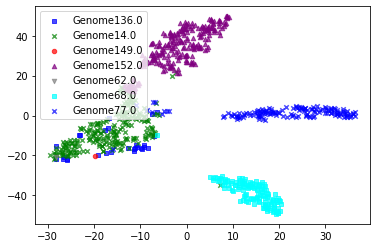

In [16]:
tsne_results = pd.read_csv('experiment_beta800/complexity_sim_10_genera_250_genomes_tsne.tsv', sep='\t')
fig = category_scatter(x='0', y='1', label_col='genome_id', 
                       data=tsne_results, legend_loc='upper left')